Packages:

In [64]:
import glob
import os
import warnings
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from pydicom.data import get_testdata_files
from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display

 # Import functions from the module
import importlib
import help_files._0_definitions 
import  help_files._1_visuals_script
# import  help_files._01_load_data
 # Reload the module to apply the changes to the script
importlib.reload(help_files._0_definitions)
importlib.reload(help_files._1_visuals_script)
# importlib.reload(help_files._01_load_data)
import  help_files._1_visuals_script  as pauls_vs
# Group by 'condition', 'level', and 'severity' and count occurrences
from help_files._0_definitions import count_severity_by_condition_level 
# Define the path
from pathlib import Path

pd.set_option("display.width", 1000)  # Set a large width to prevent line wrapping
 

In [109]:
### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_definitions.py") as file:
    exec(file.read())
    ### In definitions are all the functions that are used in the notebook and globals
with open("help_files/_0_run_definitions.py") as file:
    exec(file.read())

In [66]:
# loading data
file_names = ["train_df_3_cat.csv", "test_df_3_cat.csv"]
# Load the data from the CSV files
dataframes = [pd.read_csv(data_path_vor / file_name) for file_name in file_names]
# Unpack the dataframes into separate variables
train_df, test_df = dataframes

print("DataFrames have been loaded successfully.")



DataFrames have been loaded successfully.


In [67]:
train_df.dtypes

study_id           int64
severity         float64
condition          int64
level             object
series_id        float64
x                float64
y                float64
image_path        object
missing_image       bool
dtype: object

In [68]:
# # end sample or small sample    
if whole_data_set == True:
    print("Using the whole data set")
else:
    train_df = train_df.sample(n=100, random_state=RSEED)
    test_df = test_df.sample(n=100, random_state=RSEED)
    display(Markdown('<span style="color:red"> this is a small sample : 48692</span>'))

Using the whole data set


Ttrasformaiton and dataloader (do not change over models)

In [69]:
# define transformation and class

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
# %pip install torch torchvision
import torchvision.models as models
from torchvision import transforms
import pydicom
# %pip install opencv-python
import cv2
import pandas as pd


# Define the transform with augmentation: I already tranformed i tbfore 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #transforms.RandomRotation(2),       # Randomly rotate the image by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

        # Ensure severity is in integer format
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']  # Use severity for the label

        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')  # Normalize

        # Convert the image to RGB if it is grayscale
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Apply transformations including augmentation
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)

        return image_tensor, torch.tensor(label).long()  # Return label as tensor

    def __len__(self):
        return len(self.data)



In [70]:
train_data = train_df

training model resnet50 sotp if validation and train go apart

* Setting the model

In [71]:
import mlflow
import mlflow.pytorch
import random
# Set random seed for reproducibility
seed = 42  # You can choose any integer
torch.manual_seed(seed)
np.random.seed(seed)  # Set seed for numpy
random.seed(seed)  # Set seed for random module

# Create a new experiment
Resnet50_class_seg1_seg1_basic = "Resnet50_class_seg1_seg1_basic"
mlflow.set_experiment(Resnet50_class_seg1_seg1_basic)

<Experiment: artifact_location='file:///c:/Users/HP1/Desktop/Spiced/capstone-project/mlruns/711328181724227740', creation_time=1731147338980, experiment_id='711328181724227740', last_update_time=1731147338980, lifecycle_stage='active', name='Resnet50_class_seg1_seg1_basic', tags={}>

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
# %pip install keras
# %pip install tensorflow
# from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
import numpy as np  # Import numpy for setting the random seed

# Create the dataset
dataset = MRIDataset(data=train_data, transform=transform)

# Split the dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 256
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load ResNet-50 and set up for classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = train_df['severity'].nunique()

model = models.resnet50(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Define loss functions and optimizer
learining_rate = 0.0001 
criterion_cel = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learining_rate)
num_epochs = 20

# Early stopping parameters
# Lists to store loss values for plotting
train_losses_cel = []
val_losses_cel = []

# Early stopping parameters
diverge_count = 0              # Counter for divergence-based stopping
stop_threshold = 0.3           # Threshold for divergence
max_diverge_count = 3          # Max number of epochs with diverging validation loss



# Calculate number of layers in the model
num_layers = len(list(model.children()))


* setting mlflow: end running new model

Epoch [1/20], Train Cross Entropy Loss: 0.9831, Validation Cross Entropy Loss: 1.0800
Epoch [2/20], Train Cross Entropy Loss: 0.5260, Validation Cross Entropy Loss: 0.7899
Epoch [3/20], Train Cross Entropy Loss: 0.1663, Validation Cross Entropy Loss: 1.2071
Epoch [4/20], Train Cross Entropy Loss: 0.0526, Validation Cross Entropy Loss: 0.9284
Early stopping at epoch 4 due to validation loss diverging.
Training complete!


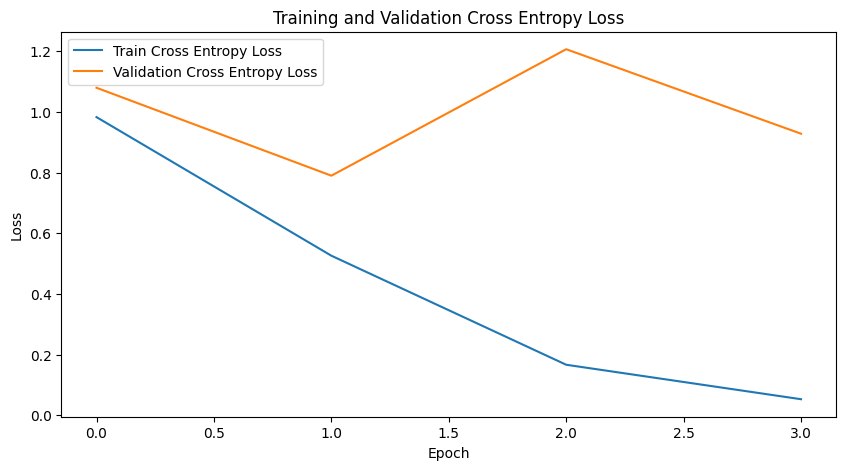

In [96]:
import torch
import numpy as np
import os
import mlflow
import matplotlib.pyplot as plt

# Start MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("learning_rate", 'learning_rate')
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("batch_size", 'batch_size')
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("model_architecture", "ResNet-50")
    
    # Log early stopping parameters
    mlflow.log_param("stop_threshold", stop_threshold)
    mlflow.log_param("max_diverge_count", max_diverge_count)
    mlflow.log_param("patience", patience)

    # Set descriptive tags for the model
    mlflow.set_tag("model_description", "ResNet-50 for 3 cat and Sagittal T2/STIR and Sagittal T1 images")

    # Example input tensor with the same shape as the model's expected input
    example_input = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 color channels, 224x224 image

    best_val_loss = float('inf')  # Initialize best validation loss
    patience_counter = 0  # Plateau counter
    patience = 5  # Number of epochs to wait for improvement before early stopping
    diverge_count = 0  # Counter for divergence-based stopping

    train_losses_cel = []  # List to store training losses
    val_losses_cel = []  # List to store validation losses

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss_cel_train = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            
            # Cross Entropy Loss
            loss_cel = criterion_cel(outputs, labels)
            running_loss_cel_train += loss_cel.item()
            
            # Backward pass and optimization
            loss_cel.backward()
            optimizer.step()

        # Calculate average training loss for the epoch
        epoch_loss_cel_train = running_loss_cel_train / len(train_loader)
        train_losses_cel.append(epoch_loss_cel_train)

        # Log training loss to MLflow
        mlflow.log_metric("train_loss_cel", epoch_loss_cel_train, step=epoch)

        # Validation phase
        model.eval()
        running_loss_cel_val = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                # Cross Entropy Loss for validation
                loss_cel = criterion_cel(outputs, labels)
                running_loss_cel_val += loss_cel.item()

        # Calculate validation loss for the epoch
        epoch_loss_cel_val = running_loss_cel_val / len(val_loader)
        val_losses_cel.append(epoch_loss_cel_val)

        # Log validation loss to MLflow
        mlflow.log_metric("val_loss_cel", epoch_loss_cel_val, step=epoch)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Cross Entropy Loss: {epoch_loss_cel_train:.4f}, '
              f'Validation Cross Entropy Loss: {epoch_loss_cel_val:.4f}')

        # Save weights for each epoch
        epoch_weight_path = f"model_weights_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), epoch_weight_path)
        mlflow.log_artifact(epoch_weight_path)  # Log model weights as artifact for each epoch
        os.remove(epoch_weight_path)  # Optionally, delete the local file after logging

        # Check for early stopping (divergence-based stopping)
        if epoch_loss_cel_val > epoch_loss_cel_train * (1 + stop_threshold):
            diverge_count += 1
            if diverge_count >= max_diverge_count:
                print(f"Early stopping at epoch {epoch + 1} due to validation loss diverging.")
                break
        else:
            diverge_count = 0  # Reset diverge count if validation loss is not diverging

        # Check for early stopping (plateau-based stopping)
        if epoch_loss_cel_val < best_val_loss:
            best_val_loss = epoch_loss_cel_val
            patience_counter = 0  # Reset plateau counter if validation loss improves
            # Save the model weights when validation loss improves (best model)
            best_model_weight_path = f"best_model_weights_epoch_{epoch + 1}.pt"
            torch.save(model.state_dict(), best_model_weight_path)
            mlflow.log_artifact(best_model_weight_path)  # Log the best model weights
            os.remove(best_model_weight_path)  # Optionally, delete the local file after logging
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} due to lack of validation loss improvement.")
                break

    print("Training complete!")

    # Log final model
    example_input_np = example_input.numpy()
    mlflow.pytorch.log_model(model, "final_model", input_example=example_input_np)

    # Plot and log the loss curves as artifacts
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_cel, label='Train Cross Entropy Loss')
    plt.plot(val_losses_cel, label='Validation Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Cross Entropy Loss')
    plt.legend()
    plt.savefig("cross_entropy_loss.png")
    mlflow.log_artifact("cross_entropy_loss.png")


In [97]:
ss

NameError: name 'ss' is not defined

In [98]:
loaded_model = mlflow.pytorch.load_model("runs:/deaa903e488043d19aad572a6c429479/final_model")
print(loaded_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [120]:
import torch
import torchvision.models as models

# Step 1: Define the model architecture (same as training)
model_for_prediciton = models.resnet50()
model_for_prediciton.fc = torch.nn.Linear(model_for_prediciton.fc.in_features, 3)  # Update for your classes

# Step 2: Load the best model weights
# Adjust this path if necessary
best_weights_path = "C:/Users/HP1/Desktop/Spiced/capstone-project/mlruns/711328181724227740/deaa903e488043d19aad572a6c429479/artifacts/best_model_weights_epoch_1.pt"
model_for_prediciton.load_state_dict(torch.load(best_weights_path))

# Step 3: Set the model to evaluation mode
model_for_prediciton.eval()
model_for_prediciton.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

C:\Users\HP1\AppData\Local\Temp\ipykernel_21028\2836263345.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_for_prediciton.load_state_dict(torch.load(best_weights_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Restore parameters and metrtics from mlflow

I should take prdicted probabilities and not predicted classes: output scores (logits) are converted into probabilities using the softmax function

In [121]:
# class definition
import mlflow
import mlflow.pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision import transforms
import pydicom
import cv2
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



# Load the model
model = model_for_prediciton
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))  # Move model to appropriate device
model.eval()  # Set the model to evaluation mode

# Prepare data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.data['severity'] = self.data['severity'].astype(int)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = row['image_path']
        label = row['severity']
        dicom_image = pydicom.dcmread(image_path)
        image = dicom_image.pixel_array.astype(float)
        image = (image / image.max() * 255).astype('uint8')
        if len(image.shape) == 2:  # Grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image_tensor = self.transform(image) if self.transform else torch.from_numpy(image).permute(2, 0, 1)
        return image_tensor, torch.tensor(label).long()

    def __len__(self):
        return len(self.data)

predicting probabilities for test data

In [122]:
test_data = test_df

In [123]:
# calculate prbabilities and probability list
test_dataset = MRIDataset(data=test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Inference loop with probability extraction
results = []
probabilities_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  # Ensure labels are also on the correct device
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Calculate class probabilities
        _, predicted_classes = torch.max(outputs, 1)
        
        # Append predictions and probabilities
        results.append(predicted_classes.item())
        probabilities_list.append(probabilities.cpu().numpy())



Using device: cpu


In [119]:
# Print predicted classes and their probabilities
for i, (pred, probs) in enumerate(zip(results, probabilities_list)):
    print(f"Test image {i}: Predicted class {pred}, Probabilities: {probs}")

# Additional code to plot the confusion matrix can stay as-is:
true_labels = []
predicted_labels = []

for images, labels in test_loader:
    images = images.to(device)
    true_labels.extend(labels.numpy())

    with torch.no_grad():
        outputs = model(images)
        _, predicted_classes = torch.max(outputs, 1)
        predicted_labels.extend(predicted_classes.cpu().numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print("True Labels Unique Values:", np.unique(true_labels))
print("Predicted Labels Unique Values:", np.unique(predicted_labels))


Test image 0: Predicted class 0, Probabilities: [[0.37055486 0.36146677 0.2679783 ]]
Test image 1: Predicted class 0, Probabilities: [[0.43520343 0.27327222 0.29152432]]
Test image 2: Predicted class 0, Probabilities: [[0.38838774 0.27565816 0.33595416]]
Test image 3: Predicted class 0, Probabilities: [[0.4226452  0.2621567  0.31519818]]
Test image 4: Predicted class 2, Probabilities: [[0.33399364 0.3259985  0.34000784]]
Test image 5: Predicted class 0, Probabilities: [[0.37230906 0.33029082 0.29740012]]
Test image 6: Predicted class 0, Probabilities: [[0.38914508 0.32320157 0.28765336]]
Test image 7: Predicted class 0, Probabilities: [[0.46982306 0.29089364 0.23928326]]
Test image 8: Predicted class 0, Probabilities: [[0.46815228 0.22690259 0.30494517]]
Test image 9: Predicted class 0, Probabilities: [[0.35322845 0.31422254 0.33254904]]
Test image 10: Predicted class 0, Probabilities: [[0.3591793  0.34761375 0.29320693]]
Test image 11: Predicted class 1, Probabilities: [[0.331925   0.

KeyboardInterrupt: 

In [115]:
# Convert the list of probabilities to a numpy array for easier manipulation
probabilities_array = np.vstack(probabilities_list)

# Ensure the length of probabilities_array matches the length of test_df
probabilities_array = probabilities_array[:len(test_df)]

# Add the probabilities to the test_df DataFrame
test_df['Probability_Class_0'] = probabilities_array[:, 0]
test_df['Probability_Class_1'] = probabilities_array[:, 1]
test_df['Probability_Class_2'] = probabilities_array[:, 2]

# Round the probabilities to 4 decimal places
test_df['Probability_Class_0'] = test_df['Probability_Class_0'].round(4)
test_df['Probability_Class_1'] = test_df['Probability_Class_1'].round(4)
test_df['Probability_Class_2'] = test_df['Probability_Class_2'].round(4)
# Add the predicted classes to the test_df DataFrame
test_df['Predicted_Class'] = results



# Display the updated DataFrame
 
test_df.head()

,study_id,severity,condition,level,series_id,x,y,image_path,missing_image,Probability_Class_0,Probability_Class_1,Probability_Class_2,Predicted_Class
0,4003253,0,0,l5/s1,1.054714e+09,197.100569,289.457306,data/train_images_origin/4003253/702807833/3.dcm,False,0.3706,0.3615,0.2680,0
1,4646740,1,0,l5/s1,3.486248e+09,235.980844,360.313610,data/train_images_origin/4646740/3486248476/2.dcm,False,0.4352,0.2733,0.2915,0
2,4646740,1,0,l5/s1,3.486248e+09,235.980844,360.313610,data/train_images_origin/4646740/3666319702/16...,False,0.3884,0.2757,0.3360,0
3,4646740,1,0,l5/s1,3.486248e+09,235.980844,360.313610,data/train_images_origin/4646740/3486248476/16...,False,0.4226,0.2622,0.3152,0
4,4646740,1,0,l5/s1,3.486248e+09,235.980844,360.313610,data/train_images_origin/4646740/3666319702/10...,False,0.3340,0.3260,0.3400,2


In [116]:
# Group by severity and sum the Probability_Class_1
severity_prob_sum_all_classes = test_df.groupby('severity')[['Probability_Class_0', 'Probability_Class_1', 'Probability_Class_2']].mean()

# Print the result
severity_prob_sum_all_classes
# Use severity_prob_sum_all_classes as confusion matrix
conf_matrix_prob_df = severity_prob_sum_all_classes 
# Create a confusion matrix from severity and predicted class
conf_matrix_severity_pred = confusion_matrix(test_df['severity'], test_df['Predicted_Class'])

# Create a DataFrame from the confusion matrix
conf_matrix_severity_pred_df = pd.DataFrame(
    conf_matrix_severity_pred, 
    index=[f"Actual {i}" for i in range(len(conf_matrix_severity_pred))], 
    columns=[f"Predicted {i}" for i in range(len(conf_matrix_severity_pred[0]))]
)

# Print the confusion matrix DataFrame
print(conf_matrix_severity_pred_df)

# Optionally, display it using a more formatted view (e.g., in Jupyter Notebook)
conf_matrix_severity_pred_df.style.background_gradient(cmap='Blues')
# Print the confusion matrix DataFrame
print(conf_matrix_prob_df)

# Optionally, display it using a more formatted view (e.g., in Jupyter Notebook)
conf_matrix_prob_df.style.background_gradient(cmap='Blues')


          Predicted 0  Predicted 1  Predicted 2
Actual 0         2006         1068           48
Actual 1         2127         1135           44
Actual 2         1890         1186           69
          Probability_Class_0  Probability_Class_1  Probability_Class_2
severity                                                               
0                    0.381938             0.348766             0.269297
1                    0.380893             0.348273             0.270834
2                    0.377788             0.349122             0.273092


,Probability_Class_0,Probability_Class_1,Probability_Class_2
severity,,,
0,0.381938,0.348766,0.269297
1,0.380893,0.348273,0.270834
2,0.377788,0.349122,0.273092


In [114]:
conf_matrix_severity_pred_df.style.background_gradient(cmap='Blues')

,Predicted 0,Predicted 1,Predicted 2
Actual 0,2006,1068,48
Actual 1,2127,1135,44
Actual 2,1890,1186,69


In [117]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Ensure true_labels and predicted_labels have the same length
min_length = min(len(true_labels), len(predicted_labels))
true_labels = true_labels[:min_length]
predicted_labels = predicted_labels[:min_length]

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(
    conf_matrix, 
    index=[f"Actual {i}" for i in range(len(conf_matrix))], 
    columns=[f"Predicted {i}" for i in range(len(conf_matrix[0]))]
)

# Print the confusion matrix DataFrame
print(conf_matrix_df)

# Optionally, display it using a more formatted view (e.g., in Jupyter Notebook)
conf_matrix_df.style.background_gradient(cmap='Blues')


          Predicted 0  Predicted 1  Predicted 2
Actual 0           22           11            1
Actual 1           17           12            1
Actual 2           21           13            2


,Predicted 0,Predicted 1,Predicted 2
Actual 0,22,11,1
Actual 1,17,12,1
Actual 2,21,13,2


In [118]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Calculate precision, recall, and accuracy using mean_probabilities_df
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Precision: 0.4047
Recall: 0.3600
Accuracy: 0.3600
